
### Analysis of LFADS input timing 

This is an examination of when LFADS controller outputs occur. As shown below, the inputs are sparse in time, and so the goal is to determine when the sharp peaks occur

TODO: measures of sparsity of the inputs

As is evident from the plots, peaks in the controller outputs tend to occur immediately after target appearances. The following is a distribution of latencies between taret appearances and the next peak, for peaks which occur within 500ms of a target appearance. I'll use a range of thresholds for peak appearances.

In [1]:
from scipy.io import loadmat
import sys
import h5py
sys.path.insert(0, '/home/pmalonis/lfads_analysis/src')
import utils
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

trial_type = 'all'

lfads_filename = "/home/pmalonis/lfads_analysis/data/model_output/raju_2OLS24_all.h5"
data_filename = "/home/pmalonis/lfads_analysis/data/intermediate/raju.p"
inputInfo_filename = "/home/pmalonis/lfads_analysis/data/model_output/raju_inputInfo.mat"

input_info = loadmat(inputInfo_filename)
used_inds = utils.get_indices(input_info, trial_type)

df = pd.read_pickle(data_filename)

ntrials = 10
with h5py.File(sparse_filename) as h5file:
    trial_len_ms = input_info['seq_timeVector'][-1][-1]
    dt = np.round(trial_len_ms/h5file['controller_outputs'].shape[1])/1000 
    trial_len = trial_len_ms/1000
    trial_len = np.floor(trial_len/dt)*dt
    lfads_t = np.arange(0, trial_len, dt)
    plt.figure(figsize=(8,20))
    for i, trial_idx in enumerate(used_inds[:ntrials]):
        plt.subplot(ntrials, 1, i + 1)
        n_inputs = h5file['controller_outputs'].shape[2]
        targets = df.loc[trial_idx].kinematic.loc[:trial_len].query('hit_target').index.values
        plt.vlines(targets, -.8,.8)
        legend = []
        for input_idx in range(n_inputs):
            plt.plot(lfads_t, h5file['controller_outputs'][i,:,input_idx])
            legend.append('input %d'%input_idx)

        plt.legend(legend)

NameError: name 'sparse_filename' is not defined

In [2]:
import sys
sys.path.insert(0, '/home/pmalonis/lfads_analysis/src')
import timing_analysis as ta
import segment_submovements as ss
import seaborn as sns
from scipy import io
import utils
import importlib
import pandas as pd
import h5py
import utils
import numpy as np
import matplotlib.pyplot as plt
importlib.reload(ta)
importlib.reload(ss)
importlib.reload(utils)

trial_type = 'all'
lfads_filename = "/home/pmalonis/lfads_analysis/data/model_output/raju_2OLS24_all.h5"
data_filename = "/home/pmalonis/lfads_analysis/data/intermediate/raju.p"
inputInfo_filename = "/home/pmalonis/lfads_analysis/data/model_output/raju_inputInfo.mat"

#limits of window to look for peaks after target appearance
win_start = 0
win_stop = 0.5
# minimum distance between peaks
min_distance = 5

df = pd.read_pickle(data_filename)
input_info = io.loadmat(inputInfo_filename)
with h5py.File(lfads_filename) as h5file:
    co = h5file['controller_outputs'][:]
    dt = utils.get_dt(h5file, input_info)
    trial_len = utils.get_trial_len(h5file, input_info)
    n_inputs = h5file['controller_outputs'].shape[2]

/home/pmalonis/miniconda3/envs/lfads_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:31: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.


In [4]:
import os
import pickle
import importlib
importlib.reload(ta)
importlib.reload(ss)
importlib.reload(utils)

peak_df_filename = '../data/model_output/peak_latency_' + lfads_filename.split('/')[-1].split('.')[0] + '.p'
peak_thresholds = [.1, .2, .3, .4]
if False:#os.path.exists(peak_df_filename):
    peak_dfs = pickle.load(open(peak_df_filename, 'rb'))
else:
    peak_dfs = []
    for peak_thresh in peak_thresholds:
        targets = ta.get_targets(df)
        peaks = ta.get_peaks(co, dt, peak_thresh, min_distance)
        target_peaks, peak_counts = ta.get_latencies(targets, peaks, win_start, win_stop, trial_len=trial_len)
        peak_dfs.append(target_peaks)

    pickle.dump(peak_dfs, open(peak_df_filename, 'wb'))

/home/pmalonis/miniconda3/envs/lfads_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less
  if sys.path[0] == '':


Series([], Name: latency_1, dtype: float64)


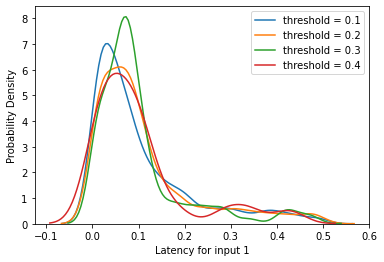

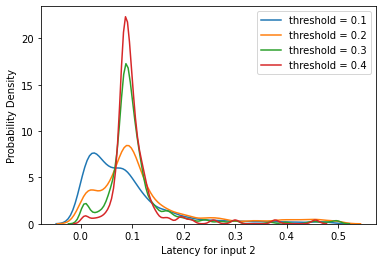

In [54]:
for i in range(n_inputs):
    plt.figure()
    for j, p in enumerate(peak_thresholds):
        label = 'threshold = %0.1f'%p
        sns.distplot(peak_dfs[j]['latency_%d'%i].values, 
                     hist=False, label=label)

    plt.legend()
    plt.xlabel('Latency for input %d'%(i+1))
    plt.ylabel('Probability Density')
    
print(peak_dfs[j]['latency_%d'%i][peak_dfs[j]['latency_%d'%i].values<0])

Text(0.5, 1.0, 'Raju')

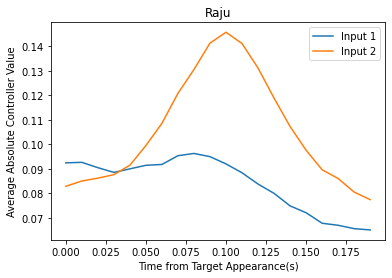

In [5]:
pkdf = peak_dfs[2]
window = 0.2
pkdf = pkdf.iloc[np.where(pkdf.index.get_level_values('time') < trial_len - window)]
ctrl_avg = np.zeros((co.shape[2],int(window/dt)))
for n, (trial, time) in enumerate(pkdf.index):
    idx_start = int(time/dt)
    idx_stop = int((time + window)/dt)
    ctrl_avg = (n/(n+1)) * ctrl_avg + np.abs(co[trial,idx_start:idx_stop,:].T)/(n+1)
    
t = np.arange(0, window, dt)
plt.plot(t,ctrl_avg[0])
plt.plot(t,ctrl_avg[1])
#plt.plot(t,ctrl_avg.mean(0))
plt.xlabel('Time from Target Appearance(s)')
plt.ylabel('Average Absolute Controller Value')
plt.legend(['Input 1', 'Input 2'])
plt.title('Raju')

In [4]:
from importlib import reload
reload(ta)
total_targets = targets.shape[0]
inputs = list(range(n_inputs))
targets_with_peak = [ta.get_target_peak_counts(target_peaks, input_idx) for input_idx in inputs]
targets_any = ta.get_target_peak_counts(target_peaks, inputs, all_inputs=False)
targets_all = ta.get_target_peak_counts(target_peaks, inputs, all_inputs=True)

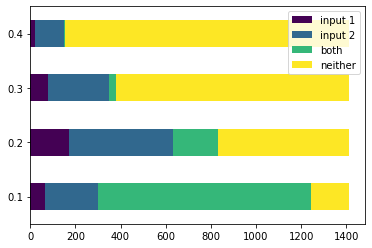

In [12]:
import matplotlib

bardf=pd.DataFrame({'input 1':[(peak_dfs[i].latency_0.notnull() & peak_dfs[i].latency_1.isnull()).sum() for i in range(len(peak_dfs))],
'input 2':[(peak_dfs[i].latency_1.notnull() & peak_dfs[i].latency_0.isnull()).sum() for i in range(len(peak_dfs))],
'both':[(peak_dfs[i].latency_1.notnull() & peak_dfs[i].latency_0.notnull()).sum() for i in range(len(peak_dfs))],
'neither':[(peak_dfs[i].latency_1.isnull() & peak_dfs[i].latency_0.isnull()).sum() for i in range(len(peak_dfs))]},
index=peak_thresholds)

cmap = matplotlib.cm.get_cmap('viridis')
rgba = cmap(np.linspace(0,1,len(peak_thresholds)))
ax = bardf.plot.barh(stacked=True, color=rgba)
fig = ax.get_figure()

Text(0, 0.5, 'Probability Density')

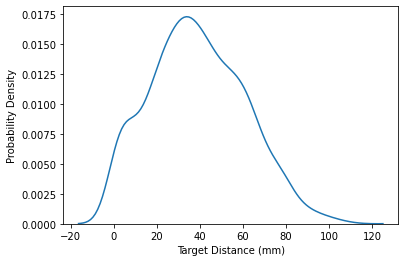

In [10]:
best_threshold = 0.2
i = peak_thresholds.index(best_threshold) #index of best threshold
pkdf = peak_dfs[i]
x = pkdf.target_x-pkdf.x
y = pkdf.target_y-pkdf.y
dist = np.sqrt(x**2 + y**2)
sns.distplot(dist, hist=False)
plt.xlabel('Target Distance (mm)')
plt.ylabel('Probability Density')

In [16]:
peak_dfs_trunc = [peak_df.loc[dist<60] for peak_df in peak_dfs]
peak_dfs_trunc[2].shape

(1151, 9)

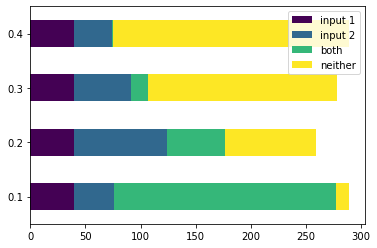

In [23]:
dist_thresh = 60
peak_dfs_trunc = []
for pkdf in peak_dfs:
    x = pkdf.target_x-pkdf.x
    y = pkdf.target_y-pkdf.y
    dist = np.sqrt(x**2 + y**2)
    peak_dfs_trunc.append(pkdf.loc[dist>dist_thresh])
    
bardf=pd.DataFrame({'input 1':[(peak_dfs_trunc[i].latency_0.notnull() & peak_dfs_trunc[i].latency_1.isnull()).sum()],
'input 2':[(peak_dfs_trunc[i].latency_1.notnull() & peak_dfs_trunc[i].latency_0.isnull()).sum() for i in range(len(peak_dfs))],
'both':[(peak_dfs_trunc[i].latency_1.notnull() & peak_dfs_trunc[i].latency_0.notnull()).sum() for i in range(len(peak_dfs))],
'neither':[(peak_dfs_trunc[i].latency_1.isnull() & peak_dfs_trunc[i].latency_0.isnull()).sum() for i in range(len(peak_dfs))]},
index=peak_thresholds)

cmap = matplotlib.cm.get_cmap('viridis')
rgba = cmap(np.linspace(0,1,len(peak_thresholds)))
ax = bardf.plot.barh(stacked=True, color=rgba)
fig = ax.get_figure()

x          y       x_vel       y_vel  hit_target  \
trial time                                                                 
0     0.001900 -35.135831 -17.777180   66.202915  -94.616177        True   
      0.667900  34.376451 -10.217115  146.750546   81.175131        True   
      1.185867 -23.161457   4.773564 -144.971899  151.635521        True   
      1.637867 -40.938458  -0.480995   34.288825 -195.226697        True   
      2.255833  21.635624   1.626985  250.004339   39.332435        True   
...                   ...        ...         ...         ...         ...   
320   0.803900  -3.567795  23.787439 -151.637438   86.086317        True   
      1.393900   2.479613  13.332180  124.207741 -165.603836        True   
      2.453867  23.700935  46.164640  172.654769    0.182981        True   
321   0.001933  12.889202  -6.829212  -40.343693   -0.028854        True   
      2.253867 -24.602296 -12.427563   98.991543  -63.097705        True   

                 target_x   target_y  latency_0  latency_1  
trial time                                                  
0     0.001900  34.376451 -10.217115        NaN        NaN  
      0.667900 -23.161457   4.773564        NaN   0.032100  
      1.185867 -40.938458  -0.480995        NaN        NaN  
      1.637867  21.635624   1.626985        NaN        NaN  
      2.255833   8.531501  -0.130767        NaN   0.024167  
...                   ...        ...        ...        ...  
320   0.803900   2.479613  13.332180        NaN        NaN  
      1.393900  23.700935  46.164640        NaN        NaN  
      2.453867  28.466885 -45.182342   0.236133   0.196133  
321   0.001933 -24.602296 -12.427563   0.208067        NaN  
      2.253867  13.078805  15.163514        NaN        NaN  

[1412 rows x 9 columns]

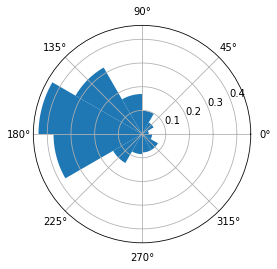

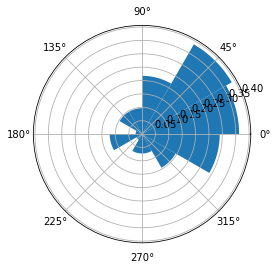

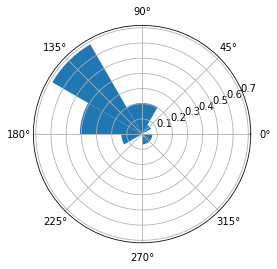

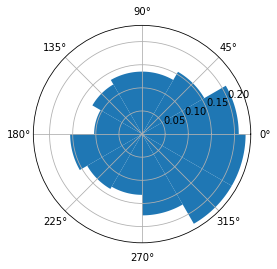

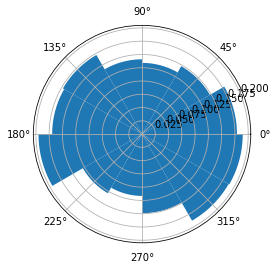

In [7]:
single_peak_thetas = []
peak_idx = []
pkdf = peak_dfs[i]
x = pkdf.target_x-pkdf.x
y = pkdf.target_y-pkdf.y
theta=np.arctan2(y, x)[pkdf.latency_1.notnull() & pkdf.latency_0.isnull()].values
utils.polar_hist(theta, 12)
single_peak_thetas.append(theta)
peak_idx.append(np.ones(len(theta)))
plt.figure()
theta=np.arctan2(y, x)[pkdf.latency_0.notnull() & pkdf.latency_1.isnull()].values
single_peak_thetas.append(theta)
peak_idx.append(2*np.ones(len(theta)))
utils.polar_hist(theta, 12)
plt.figure()
theta=np.arctan2(y, x)[pkdf.latency_0.notnull() & pkdf.latency_1.notnull()].values
utils.polar_hist(theta, 12)
theta=np.arctan2(y, x)[pkdf.latency_0.isnull() & pkdf.latency_1.isnull()].values
plt.figure()
utils.polar_hist(theta, 12)
theta=np.arctan2(y, x)
plt.figure()
utils.polar_hist(theta, 12)

single_peak_thetas = np.concatenate(single_peak_thetas)
peak_idx = np.concatenate(peak_idx)

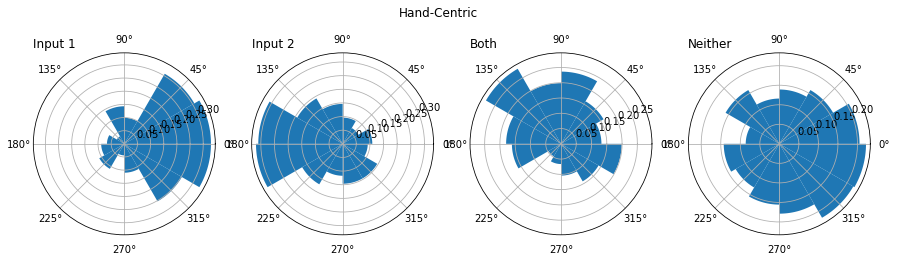

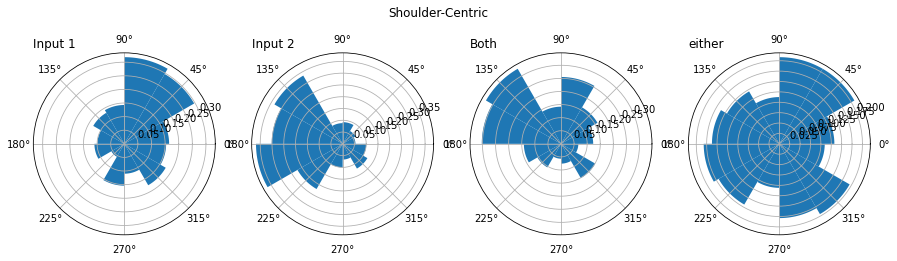

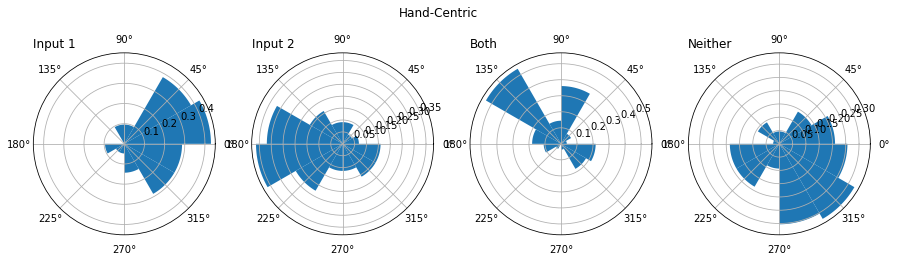

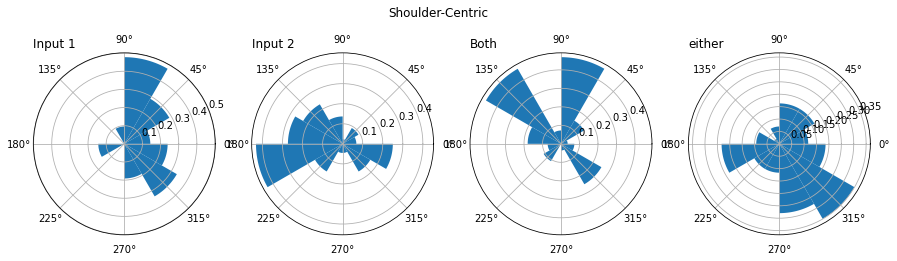

In [32]:
importlib.reload(utils)
best_threshold = 0.2
i = peak_thresholds.index(best_threshold) #index of best threshold

for pkdf in [peak_dfs[i], peak_dfs_trunc[i]]:
    fig = plt.figure(figsize=(15,4))
    fig.suptitle('Hand-Centric')

    ax = plt.subplot(1, 4, 1, polar=True)
    ax.set_title('Input 1', loc='left')
    x = pkdf.target_x-pkdf.x
    y = pkdf.target_y-pkdf.y
    theta_shoulder = np.arctan2(y, x)[pkdf.latency_0.notnull() & pkdf.latency_1.isnull()].values
    utils.polar_hist(theta_shoulder, 12, ax)

    theta_hand = np.arctan2(y, x)[pkdf.latency_1.notnull() & pkdf.latency_0.isnull()].values
    ax = plt.subplot(1, 4, 2, polar=True)
    ax.set_title('Input 2', loc='left')
    utils.polar_hist(theta_hand, 12, ax)

    theta_shoulder = np.arctan2(y, x)[pkdf.latency_0.notnull() & pkdf.latency_1.notnull()].values
    ax = plt.subplot(1, 4, 3, polar=True)
    ax.set_title('Both', loc='left')
    utils.polar_hist(theta_shoulder, 12, ax)

    theta_shoulder = np.arctan2(y, x)[pkdf.latency_1.isnull() & pkdf.latency_0.isnull()].values
    ax = plt.subplot(1, 4, 4, polar=True)
    ax.set_title('Neither', loc='left')
    utils.polar_hist(theta_shoulder, 12, ax)

    fig = plt.figure(figsize=(15,4))
    fig.suptitle('Shoulder-Centric')

    x = pkdf.target_x
    y = pkdf.target_y
    theta_shoulder = np.arctan2(y, x)[pkdf.latency_0.notnull() & pkdf.latency_1.isnull()].values
    ax = plt.subplot(1, 4, 1, polar=True)
    ax.set_title('Input 1', loc='left')
    utils.polar_hist(theta_shoulder, 12, ax)

    theta_shoulder = np.arctan2(y, x)[pkdf.latency_1.notnull() & pkdf.latency_0.isnull()].values
    ax = plt.subplot(1, 4, 2, polar=True)
    ax.set_title('Input 2', loc='left')
    utils.polar_hist(theta_shoulder, 12, ax)

    theta_shoulder = np.arctan2(y, x)[pkdf.latency_0.notnull() & pkdf.latency_1.notnull()].values
    ax = plt.subplot(1, 4, 3, polar=True)
    ax.set_title('Both', loc='left')
    utils.polar_hist(theta_shoulder, 12, ax)

    theta_shoulder = np.arctan2(y, x)[pkdf.latency_1.isnull() & pkdf.latency_0.isnull()].values
    ax = plt.subplot(1, 4, 4, polar=True)
    ax.set_title('either', loc='left')
    utils.polar_hist(theta_shoulder, 12, ax)

Now we'll look at the correlation between target position in the two coordinate frames.

Correlation: -0.464153


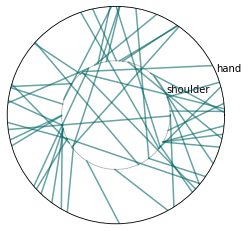

In [10]:
import sys
sys.path.insert(0, '../src/')
import utils
import importlib
from astropy.stats import circcorrcoef
importlib.reload(utils)

pkdf = peak_dfs[2]
theta_shoulder = np.arctan2(pkdf.target_y, pkdf.target_x)
theta_hand = np.arctan2(pkdf.target_y - pkdf.y, pkdf.target_x - pkdf.x)
print("Correlation: %f"%circcorrcoef(theta_shoulder, theta_hand))
plt.figure()
utils.spoke_plot(theta_shoulder[:50], theta_hand[:50], ['shoulder', 'hand'])

/home/pmalonis/miniconda3/envs/lfads_analysis/lib/python3.6/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


/home/pmalonis/miniconda3/envs/lfads_analysis/lib/python3.6/site-packages/matplotlib/projections/polar.py:55: RuntimeWarning: invalid value encountered in greater_equal
  r = np.where(r >= 0, r, np.nan)


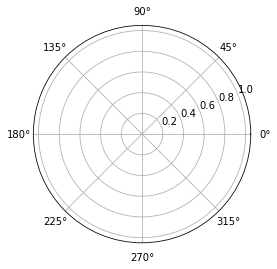

In [13]:
minx = np.min(peak_dfs[2].target_x.values)
maxx = np.max(peak_dfs[2].target_x.values)
miny = np.min(peak_dfs[2].target_y.values)
maxy = np.max(peak_dfs[2].target_y.values)

x = np.diff(np.random.rand(2,10000)*(maxx-minx) + minx, axis=0)
y = np.diff(np.random.rand(2,10000)*(maxy-miny) + miny, axis=0)

theta = np.arctan2(y,x)
utils.polar_hist(theta, 12)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

pkdf = peak_dfs[2]
pkdf['input'] = ''

pkdf.loc[pkdf.latency_0.notnull() & pkdf.latency_1.isnull(),'input'] = 'input_1'
pkdf.loc[pkdf.latency_0.isnull() & pkdf.latency_1.notnull(),'input'] = 'input_2'
pkdf.loc[pkdf.latency_0.notnull() & pkdf.latency_1.notnull(),'input'] = 'both'
pkdf.loc[pkdf.latency_0.isnull() & pkdf.latency_1.isnull(),'input'] = 'neither'


model = RandomForestClassifier()
#model = xgb.XGBClassifier()
#model = SVC(kernel='linear')

X = np.concatenate([pkdf[['target_x','target_y']], pkdf[['target_x', 'target_y']].values - pkdf[['x','y']].values], axis=1)
y = pkdf['input'].values
nan_rows = np.where(np.isnan(X))[0]
X = np.delete(X, nan_rows, axis=0)
y = np.delete(y, nan_rows, axis=0)
X_train, X_test, y_train, y_test = train_test_split(X,y)
model.fit(X_train,y_train)
model.score(X_test, y_test)

In [13]:
plt.bar(model.feature_importances_)

AttributeError: 'SVC' object has no attribute 'feature_importances_'

In [45]:
right_1 = np.sum(peak_idx[(-np.pi/2 <= single_peak_thetas) & (single_peak_thetas < np.pi/2)]==1)
right_2 = np.sum(peak_idx[(-np.pi/2 <= single_peak_thetas) & (single_peak_thetas < np.pi/2)]==2)
left_1 = np.sum(peak_idx[np.logical_not((-np.pi/2 <= single_peak_thetas) & (single_peak_thetas < np.pi/2))]==1)
left_2 = np.sum(peak_idx[np.logical_not((-np.pi/2 <= single_peak_thetas) & (single_peak_thetas < np.pi/2))]==2)

(left_1 + right_2)/len(single_peak_thetas)

0.6814580031695721

In [66]:
n_close_targets = 0
for i in range(pkdf.index[-1][0]+1):
    trial_idx = pkdf.loc[i].index
    n_close_targets += np.sum((trial_idx[1:]-trial_idx[:-1])<win_stop)
    
print(n_close_targets/pkdf.shape[0])

0.2669971671388102


0.2669971671388102

<Figure size 432x288 with 0 Axes>

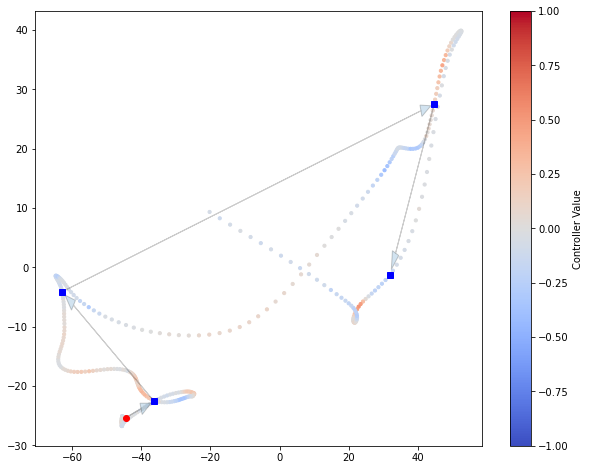

<Figure size 432x288 with 0 Axes>

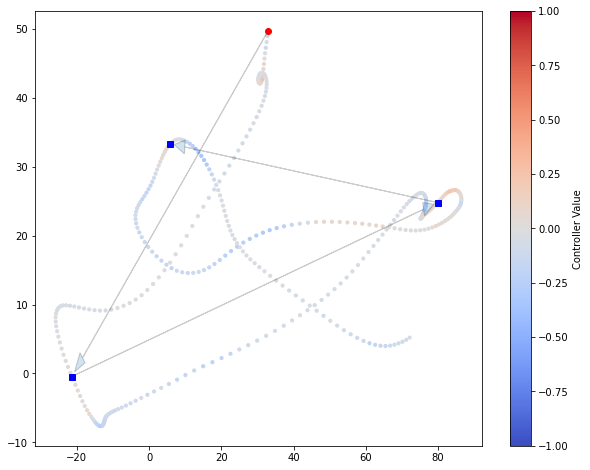

<Figure size 432x288 with 0 Axes>

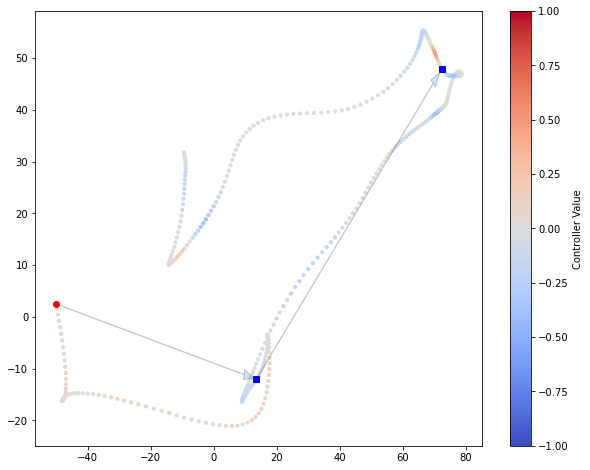

<Figure size 432x288 with 0 Axes>

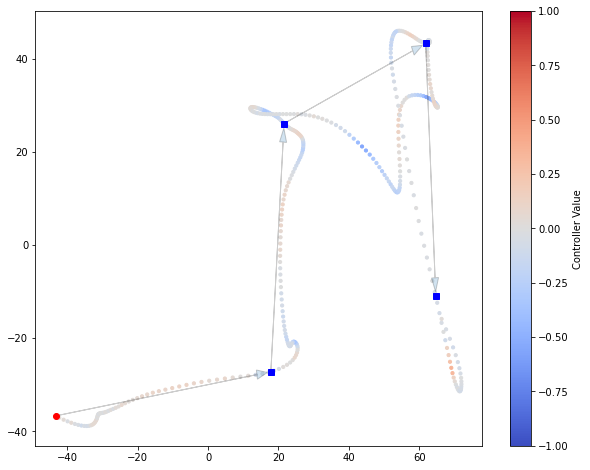

<Figure size 432x288 with 0 Axes>

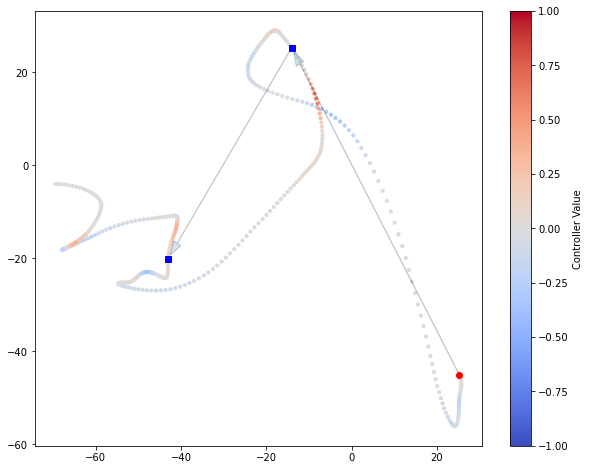

In [11]:
import matplotlib as mpl
mpl.rcParams['figure.max_open_warning'] = False
for i in range(100, 150, 10):
    plt.figure()
    ss.plot_trajectory_co(df.loc[i], co[i,:,0], dt)

In [12]:
import sys
sys.path.insert(0, '/home/pmalonis/lfads_analysis/src')
from power_law import get_curvature

n_trials = df.index[-1][0] + 1
K = []
trial_len = co.shape[1] * dt
for i in range(n_trials):
    trial_df = df.loc[i]
    t_target = trial_df.kinematic.query('hit_target').index
    idx = range(trial_df.shape[0])
    t = trial_df.index[idx]
    x = trial_df.kinematic['x'].iloc[idx].values
    y = trial_df.kinematic['y'].iloc[idx].values
    idx = [trial_df.index.get_loc(t, 'nearest') for t in np.arange(0, trial_len, dt)]
    K.append(get_curvature(x,y,t)[idx])
    
curv = np.concatenate(K)
#np.corrcoef(curv, co[:10,:,0].flatten())[0,1]

In [13]:
K_feedback = []
co_feedback = []
post_target_exclude = .25
post_target_win_size = int(post_target_exclude/dt)
for i in range(n_trials):
    targets = df.loc[i].kinematic.query('hit_target')[:trial_len].index.values
    target_dt = np.round(targets/dt).astype(int)
    target_dt = np.append(target_dt, trial_len/dt)
    intervals = [(int(tdt+post_target_win_size), int(target_dt[i+1])) for i,tdt in enumerate(target_dt[:-1])]
    for start,stop in intervals:
        K_feedback.append(K[i][start:stop])
        co_feedback.append(co[i,start:stop,0])

array([[ 1.        , -0.11088131],
       [-0.11088131,  1.        ]])

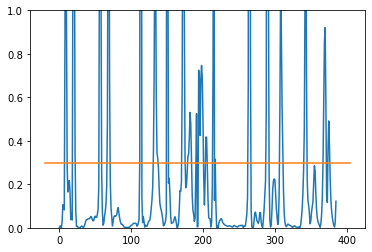

In [83]:
plt.plot(K[0])
plt.ylim([0, 1])
plt.plot(plt.xlim(), np.ones(2)*.3)

In [16]:
from numpy.linalg import norm
Ttrial = co.shape[1] #number of samples in single trial
m=co[:,:,0].mean()
nwin = 6 #half length of window to compute curvature in
#straight = np.concatenate([[norm(co[j,i-nwin:i+nwin,1]) for i in range(nwin,Ttrial-nwin) if np.all(K[j][i-nwin:i+nwin]<.1)] for j in range(n_trials)])
#curve = np.concatenate([[norm(co[j,i-nwin:i+nwin,1]) for i in range(nwin,Ttrial-nwin) if np.any(K[j][i-nwin:i+nwin]>.2)] for j in range(n_trials)])
straight = np.concatenate([[np.mean(np.abs(co_feedback[j][i-nwin:i+nwin])) for i in range(nwin,len(co_feedback[j])-nwin) if np.all(K_feedback[j][i-nwin:i+nwin]<.01)] for j in range(len(co_feedback))])
curve = np.concatenate([[np.mean(np.abs(co_feedback[j][i-nwin:i+nwin])) for i in range(nwin,len(co_feedback[j])-nwin) if np.any(K_feedback[j][i-nwin:i+nwin]>.3)] for j in range(len(co_feedback))])

0.5944949388504028
0.9008399844169617
13200
41203
MannwhitneyuResult(statistic=207886227.0, pvalue=0.0)


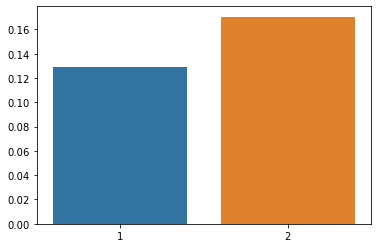

In [15]:
straight = straight[~np.isnan(straight)]
print(np.max(straight))
print(np.max(curve))
print(len(straight))
print(len(curve))

from scipy.stats import wilcoxon, mannwhitneyu
print(mannwhitneyu(straight, curve))
from seaborn import barplot
barplot([1, 2], [np.mean(straight), np.mean(curve)])

In [43]:
going=True
j=0
while going==True:
    if  np.all(K_feedback[j][i-nwin:i+nwin]<.01):
        going=False
    j+=1

range(nwin,Ttrial-nwin)

range(12, 374)

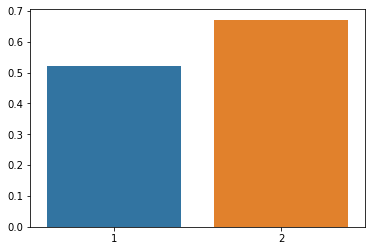

386